In [ ]:
# Setup & Imports
import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score




In [2]:
# Create directories
os.makedirs("models", exist_ok=True)
os.makedirs("plots", exist_ok=True)


print("Setup complete")

Setup complete


In [ ]:
# =========================
#  Load Dataset
# =========================


# Upload CSV manually OR load from Drive
from google.colab import files
uploaded = files.upload()


csv_path = list(uploaded.keys())[0]
df = pd.read_csv(csv_path)


df.head()

Saving crop_data.csv to crop_data (1).csv


,Crop,Crop_Year,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
0,Arecanut,1997,Whole Year,Assam,73814.0,56708,2051.4,7024878.38,22882.34,0.796087
1,Arhar/Tur,1997,Kharif,Assam,6637.0,4685,2051.4,631643.29,2057.47,0.710435
2,Castor seed,1997,Kharif,Assam,796.0,22,2051.4,75755.32,246.76,0.238333
3,Coconut,1997,Whole Year,Assam,19656.0,126905000,2051.4,1870661.52,6093.36,5238.051739
4,Cotton(lint),1997,Kharif,Assam,1739.0,794,2051.4,165500.63,539.09,0.420909


In [ ]:
# =========================
#  Data Cleaning & Feature Engineering
# =========================


# Standardize column names
df.columns = [c.strip() for c in df.columns]


# Convert numeric columns
num_cols = ['Area', 'Production', 'Annual_Rainfall', 'Fertilizer', 'Pesticide']
for c in num_cols:
  df[c] = pd.to_numeric(df[c], errors='coerce')


# Compute Yield safely
df['Area'] = df['Area'].replace(0, np.nan)
df['Yield'] = df['Production'] / df['Area']


# Drop invalid rows
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['Yield'])


# Fill missing values
for c in num_cols:
  df[c] = df[c].fillna(df[c].median())


# Clean categorical columns
for c in ['Crop', 'Season', 'State']:
  df[c] = df[c].astype(str).str.strip()


print("Cleaned dataset shape:", df.shape)

Cleaned dataset shape: (19689, 10)


In [ ]:
# =========================
# Feature & Target Split
# =========================


features = ['Crop', 'Season', 'State', 'Area', 'Annual_Rainfall', 'Fertilizer', 'Pesticide']
X = df[features]
y = df['Yield']


categorical_features = ['Crop', 'Season', 'State']
numeric_features = ['Area', 'Annual_Rainfall', 'Fertilizer', 'Pesticide']


X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42
)


print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (15751, 7)
Test size: (3938, 7)


In [ ]:
# =========================
#  Preprocessing Pipeline
# =========================


preprocessor = ColumnTransformer(
transformers=[
('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
('num', StandardScaler(), numeric_features)
]
)

In [ ]:
# =========================
#  Model Definitions
# =========================


models = {
'LinearRegression': LinearRegression(),
'DecisionTree': DecisionTreeRegressor(max_depth=8, random_state=42),
'RandomForest': RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1)
}


results = {}

In [ ]:
# =========================
#  Training, Evaluation & Plots
# =========================


for name, model in models.items():
  print(f"\nTraining {name}")
  pipeline = Pipeline([
  ('preprocessor', preprocessor),
  ('model', model)
  ])
  pipeline.fit(X_train, y_train)
  preds = pipeline.predict(X_test)
  mae = mean_absolute_error(y_test, preds)
  mse = mean_squared_error(y_test, preds)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, preds)
  results[name] = {
  'MAE': mae,
  'MSE': mse,
  'RMSE': rmse,
  'R2': r2
  }


Training LinearRegression

Training DecisionTree

Training RandomForest


In [13]:
# Save model
joblib.dump(pipeline, f'models/{name}.joblib')

['models/RandomForest.joblib']

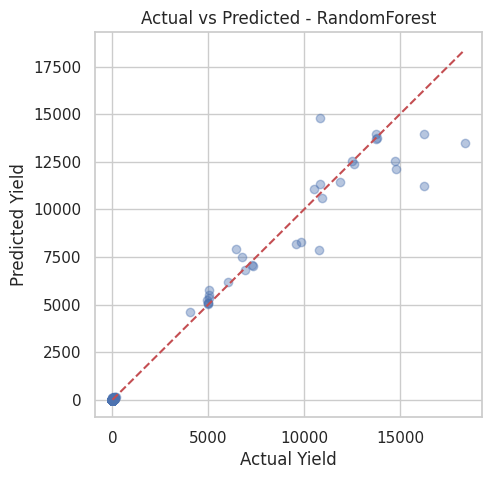

In [14]:

# Actual vs Predicted plot
plt.figure(figsize=(5,5))
plt.scatter(y_test, preds, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title(f'Actual vs Predicted - {name}')
plt.savefig(f'plots/actual_vs_pred_{name}.png')
plt.show()

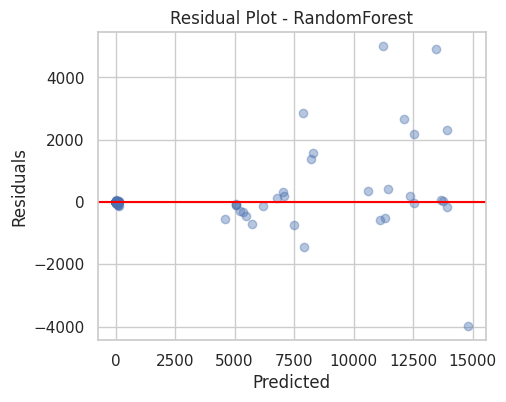

In [15]:
# Residual plot
plt.figure(figsize=(5,4))
plt.scatter(preds, y_test - preds, alpha=0.4)
plt.axhline(0, color='red')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title(f'Residual Plot - {name}')
plt.savefig(f'plots/residuals_{name}.png')
plt.show()

<Figure size 600x400 with 0 Axes>

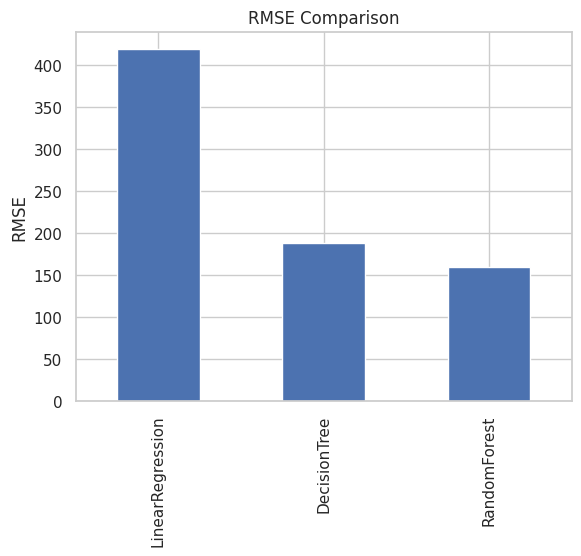

In [ ]:
# =========================
#  Metrics Comparison
# =========================


results_df = pd.DataFrame(results).T
results_df


plt.figure(figsize=(6,4))
results_df[['RMSE']].plot(kind='bar', legend=False)
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.savefig('plots/rmse_comparison.png')
plt.show()

In [ ]:
# =========================
#  Save Best Model
# =========================


best_model_name = results_df['RMSE'].idxmin()
print("Best Model:", best_model_name)


joblib.dump(
joblib.load(f'models/{best_model_name}.joblib'),
'models/best_model.joblib'
)


with open('models/metrics.json', 'w') as f:
  json.dump(results, f, indent=4)


print("Models, metrics, and plots saved successfully")

Best Model: RandomForest
Models, metrics, and plots saved successfully


In [ ]:
# =========================
# Crop Recommendation Logic (Top Crops by Season & State)
# =========================


# This logic predicts yield for ALL crops for a given Season + State
# and recommends top-N crops based on predicted yield


best_model = joblib.load('models/best_model.joblib')


all_crops = sorted(df['Crop'].unique())




def recommend_crops(season, state, area, rainfall, fertilizer, pesticide, top_n=5):
  rows = []
  for crop in all_crops:
    rows.append({
    'Crop': crop,
    'Season': season,
    'State': state,
    'Area': area,
    'Annual_Rainfall': rainfall,
    'Fertilizer': fertilizer,
    'Pesticide': pesticide
    })


  input_df = pd.DataFrame(rows)
  predictions = best_model.predict(input_df)


  rec_df = pd.DataFrame({
  'Crop': all_crops,
  'Predicted_Yield': predictions
  }).sort_values(by='Predicted_Yield', ascending=False)


  return rec_df.head(top_n)

In [ ]:
# =========================
#  Example Recommendation
# =========================


# Example: Kharif season in Assam
recommendations = recommend_crops(
season='Kharif',
state='Assam',
area=1.0,
rainfall=1800,
fertilizer=50000,
pesticide=2000,
top_n=5
)


recommendations

,Crop,Predicted_Yield
9,Coconut,5858.687825
46,Sugarcane,35.043360
37,Potato,29.336633
24,Maize,18.321765
3,Banana,15.648971


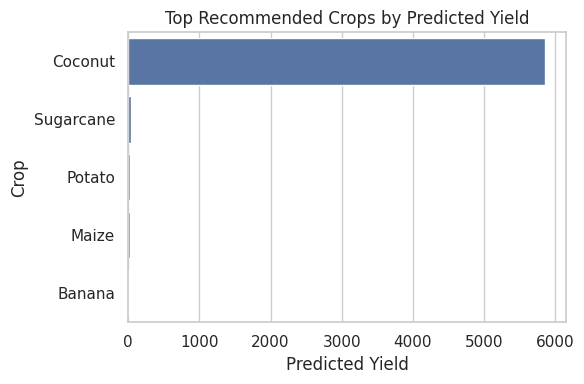

In [ ]:
# =========================
#  Visualization of Recommended Crops
# =========================


plt.figure(figsize=(6,4))
sns.barplot(
data=recommendations,
x='Predicted_Yield',
y='Crop'
)
plt.title('Top Recommended Crops by Predicted Yield')
plt.xlabel('Predicted Yield')
plt.ylabel('Crop')
plt.tight_layout()
plt.savefig('plots/top_crop_recommendations.png')
plt.show()

In [ ]:


# =========================
# Save Recommendation Metadata
# =========================


with open('models/crop_list.json', 'w') as f:
  json.dump(all_crops, f, indent=2)


files.download('models/crop_list.json')
files.download('plots/top_crop_recommendations.png')


print("Crop recommendation logic added successfully")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Crop recommendation logic added successfully
